In [3]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.endpoints import draftcombineplayeranthro
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd


In [17]:
# Get a list of all active NBA players
player_dict = players.get_active_players()

seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(2015, 2022)]

total_seasons = len(seasons)

# Store the top 10 shooters for each season
season_top_shooters = {}

for i, season in enumerate(seasons):
    season_3pt_shooters = []

    for player in player_dict:
        player_id = player['id']
        player_name = f"{player['first_name']} {player['last_name']}"

        try:
            # Get game log for the player for the specific season
            game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season)
            game_log_df = game_log.get_data_frames()[0]

            # Calculate the total 3-point attempts and makes
            total_3pa = game_log_df['FG3A'].sum()
            total_3pm = game_log_df['FG3M'].sum()

            # Check if the player has at least 100 3PA
            if total_3pa >= 100:
                efficiency_3pm = total_3pm / total_3pa
                season_3pt_shooters.append({'Player': player_name, '3PT Efficiency': efficiency_3pm, '3PA': total_3pa})

        except Exception as e:
            print(f"Error processing player {player_name} for season {season}: {str(e)}")

    # Sort the players by their three-point shooting efficiency and get the top 10
    season_top_shooters[season] = sorted(season_3pt_shooters, key=lambda x: x['3PT Efficiency'], reverse=True)[:25]

    # Print the progress
    print(f"Processed {i+1} out of {total_seasons} seasons. ({(i+1)/total_seasons*100:.2f}%)")

# Print the top 10 shooters for each season
print("\nTop 10 Three-Point Shooters by Efficiency per Season (min 100 attempts):")
for season, shooters in season_top_shooters.items():
    print(f"\n{season}:")
    for rank, shooter in enumerate(shooters, start=1):
        print(f"{rank}. {shooter['Player']} - {shooter['3PT Efficiency']:.3f} (3PA: {shooter['3PA']})")

Processed 1 out of 7 seasons. (14.29%)
Processed 2 out of 7 seasons. (28.57%)
Processed 3 out of 7 seasons. (42.86%)
Processed 4 out of 7 seasons. (57.14%)
Processed 5 out of 7 seasons. (71.43%)
Processed 6 out of 7 seasons. (85.71%)
Processed 7 out of 7 seasons. (100.00%)

Top 10 Three-Point Shooters by Efficiency per Season (min 100 attempts):

2015-16:
1. Josh Richardson - 0.461 (3PA: 115)
2. Stephen Curry - 0.454 (3PA: 886)
3. Seth Curry - 0.450 (3PA: 111)
4. Kawhi Leonard - 0.443 (3PA: 291)
5. Doug McDermott - 0.425 (3PA: 259)
6. Klay Thompson - 0.425 (3PA: 650)
7. CJ McCollum - 0.417 (3PA: 472)
8. Kelly Olynyk - 0.405 (3PA: 210)
9. Patrick Beverley - 0.400 (3PA: 310)
10. Evan Fournier - 0.400 (3PA: 390)
11. Khris Middleton - 0.396 (3PA: 361)
12. Zach LaVine - 0.389 (3PA: 316)
13. Draymond Green - 0.388 (3PA: 258)
14. Kyle Lowry - 0.388 (3PA: 547)
15. Bradley Beal - 0.387 (3PA: 271)
16. Kevin Durant - 0.387 (3PA: 481)
17. Joe Ingles - 0.386 (3PA: 210)
18. Patty Mills - 0.384 (3PA:

Coefficient: [-0.00866958]
R-squared: 0.05951371823640428


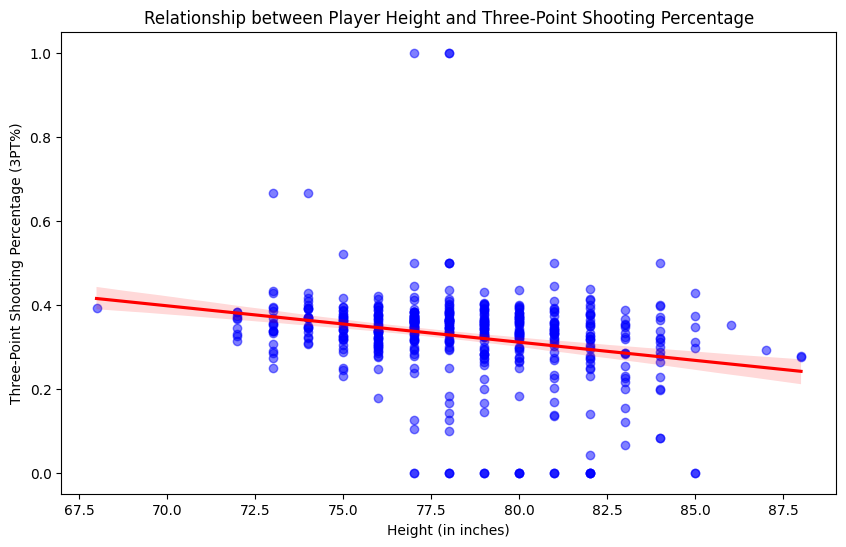

In [27]:
import random
from sklearn.linear_model import LinearRegression
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo
import seaborn as sns

def get_player_height(player_id):
    # Get player info
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    player_info = player_info.get_normalized_dict()
    player_info = player_info.get('CommonPlayerInfo')[0]

    # Return player height
    return player_info.get('HEIGHT')

# Sample code to fetch player height and 3-point percentage

player_dict = players.get_active_players()
player_data = []

for player in player_dict:
    player_id = player['id']
    player_name = player['full_name']

    # Fetch career stats for the player
    career = playercareerstats.PlayerCareerStats(player_id=player_id)
    career_df = career.get_data_frames()[0]

    # Calculate career 3-point percentage
    total_3pa = career_df['FG3A'].sum()
    total_3pm = career_df['FG3M'].sum()
    three_pt_pct = total_3pm / total_3pa if total_3pa > 0 else None

    # Get player height
    height = get_player_height(player_id)

    if height is not None and three_pt_pct is not None:
        player_data.append({'Player': player_name, 'Height': height, '3PT%': three_pt_pct})

# Create a DataFrame
df = pd.DataFrame(player_data)

# Data preprocessing steps (e.g., converting height to a numerical value) go here
def height_to_inches(height_str):
    feet, inches = height_str.split('-')
    return int(feet) * 12 + int(inches)

# Convert height to inches in the DataFrame
df['Height'] = df['Height'].apply(height_to_inches)

# Drop rows with missing values
df.dropna(inplace=True)

# Create a linear regression model
X = df[['Height']]
y = df['3PT%']
model = LinearRegression().fit(X, y)

# Output the coefficient and R-squared value
print('Coefficient:', model.coef_)
print('R-squared:', model.score(X, y))
plt.figure(figsize=(10, 6))
sns.regplot(x='Height', y='3PT%', data=df, scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={'color':'red'})

plt.title('Relationship between Player Height and Three-Point Shooting Percentage')
plt.xlabel('Height (in inches)')
plt.ylabel('Three-Point Shooting Percentage (3PT%)')
plt.show()

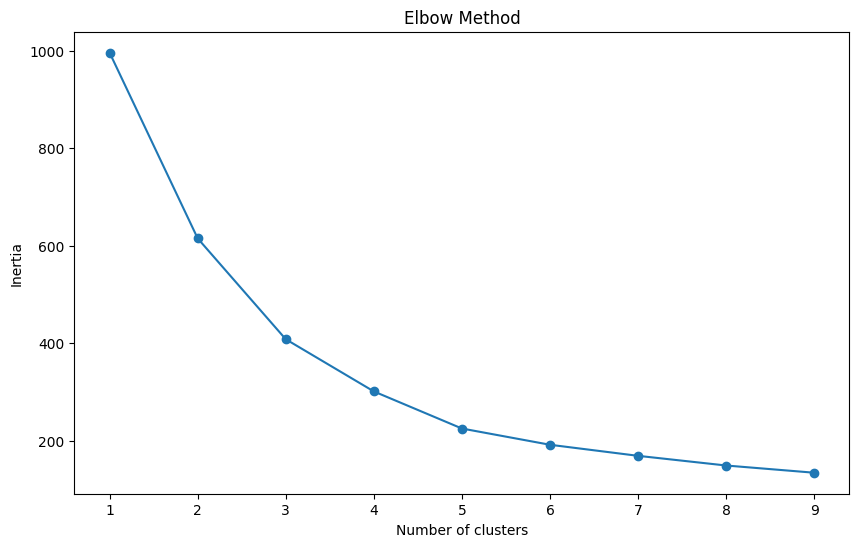


Cluster 0:
Average Height: 82.48076923076923
Average 3PT%: 0.3224828394862449

Cluster 1:
Average Height: 76.0
Average 3PT%: 0.8666666666666666

Cluster 2:
Average Height: 80.27272727272727
Average 3PT%: 0.06653092676324991

Cluster 3:
Average Height: 78.4046511627907
Average 3PT%: 0.35188183213656826

Cluster 4:
Average Height: 74.65384615384616
Average 3PT%: 0.34599352808346123


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to convert height from 'feet-inches' to inches
# Fetching player height and 3-point percentage
player_dict = players.get_active_players()
player_data = []

for player in player_dict:
    player_id = player['id']
    player_name = player['full_name']

    career = playercareerstats.PlayerCareerStats(player_id=player_id)
    career_df = career.get_data_frames()[0]

    total_3pa = career_df['FG3A'].sum()
    total_3pm = career_df['FG3M'].sum()
    three_pt_pct = total_3pm / total_3pa if total_3pa > 0 else None

    height = get_player_height(player_id)

    if height is not None and three_pt_pct is not None:
        player_data.append({'Player': player_name, 'Height': height, '3PT%': three_pt_pct})

df = pd.DataFrame(player_data)
df['Height'] = df['Height'].apply(height_to_inches)
df.dropna(inplace=True)

# Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Height', '3PT%']])

# Determine the optimal number of clusters (Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose a number of clusters based on the Elbow plot (e.g., 3)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Add cluster information to the DataFrame
df['Cluster'] = clusters

# Analyze the clusters
for i in range(n_clusters):
    cluster_data = df[df['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"Average Height: {cluster_data['Height'].mean()}")
    print(f"Average 3PT%: {cluster_data['3PT%'].mean()}")

In [31]:
from nba_api.stats.endpoints import draftcombinestats, playercareerstats, commonplayerinfo
from nba_api.stats.static import players
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

combine_data = draftcombinestats.DraftCombineStats().get_data_frames()[0]

# Fetching player height and 3-point percentage
player_dict = players.get_active_players()
player_data = []

for player in player_dict:
    player_id = player['id']
    player_name = player['full_name']

    career = playercareerstats.PlayerCareerStats(player_id=player_id)
    career_df = career.get_data_frames()[0]

    total_3pa = career_df['FG3A'].sum()
    total_3pm = career_df['FG3M'].sum()
    three_pt_pct = total_3pm / total_3pa if total_3pa > 0 else None

    height = get_player_height(player_id)
    
    if height is not None and three_pt_pct is not None:
        player_data.append({'Player': player_name, 'Height': height, '3PT%': three_pt_pct})

df = pd.DataFrame(player_data)
df['Height'] = df['Height'].apply(height_to_inches)

# Drop rows with missing height
df.dropna(subset=['Height'], inplace=True)

# Merge with combine data (wingspan, hand length, hand width)
combine_data_relevant = combine_data[['PLAYER_NAME', 'WINGSPAN', 'HAND_LENGTH', 'HAND_WIDTH']].rename(columns={'PLAYER_NAME': 'Player'})
df = df.merge(combine_data_relevant, on='Player', how='inner')

# Drop rows with missing data in any column
df.dropna(inplace=True)

# Normalize the features
scaler = StandardScaler()
features = ['Height', 'WINGSPAN', 'HAND_LENGTH', 'HAND_WIDTH']
X_scaled = scaler.fit_transform(df[features])

# Create and fit the model
model = LinearRegression().fit(X_scaled, df['3PT%'])

# Output the coefficients and R-squared value
print('Coefficients:', model.coef_)
print('R-squared:', model.score(X_scaled, df['3PT%']))

Coefficients: [-0.11062057  0.0314202  -0.04721536  0.0196081 ]
R-squared: 0.15130213060778852


In [18]:
# Assuming 'top_shooters' is your list of top 10 three-point shooters for each season
# Example: top_shooters = ['Stephen Curry', 'Klay Thompson', ...]

# Load the CSV file into a DataFrame
df = pd.read_csv("C:/Users/tajin/Downloads/final-player-data-all.csv")

# Function to get height and wingspan from the DataFrame
def get_height_and_wingspan(player_name, df):
    player_data = df[df['Player'] == player_name]
    if not player_data.empty:
        height = player_data['Height-in'].values[0]
        wingspan = player_data['Wingspan-in'].values[0]
        return height, wingspan
    else:
        return None, None

# Extract height and wingspan for each top shooter
for season, shooters in season_top_shooters.items():
    print(f"\n{season}:")
    for shooter in shooters:
        player_name = shooter['Player']
        height, wingspan = get_height_and_wingspan(player_name, df)
        if height and wingspan:
            print(f"{player_name}: Height = {height} in, Wingspan = {wingspan} in")
        else:
            print(f"{player_name}: Not found in CSV")


2015-16:
Josh Richardson: Height = 78.0 in, Wingspan = 82.0 in
Stephen Curry: Height = 74.0 in, Wingspan = 75.5 in
Seth Curry: Not found in CSV
Kawhi Leonard: Height = 78.0 in, Wingspan = 87.0 in
Doug McDermott: Height = 78.25 in, Wingspan = 81.25 in
Klay Thompson: Height = 77.75 in, Wingspan = 81.0 in
CJ McCollum: Not found in CSV
Kelly Olynyk: Height = 82.75 in, Wingspan = 81.75 in
Patrick Beverley: Height = 73.0 in, Wingspan = 77.5 in
Evan Fournier: Height = 79.0 in, Wingspan = 79.5 in
Khris Middleton: Height = 78.75 in, Wingspan = 82.75 in
Zach LaVine: Height = 76.5 in, Wingspan = 80.25 in
Draymond Green: Height = 77.75 in, Wingspan = 85.25 in
Kyle Lowry: Height = 73.0 in, Wingspan = 76.0 in
Bradley Beal: Height = 75.25 in, Wingspan = 80.0 in
Kevin Durant: Height = 81.0 in, Wingspan = 88.75 in
Joe Ingles: Height = 79.75 in, Wingspan = 82.25 in
Patty Mills: Height = 71.25 in, Wingspan = 74.0 in
Eric Gordon: Height = 74.0 in, Wingspan = 81.0 in
Harrison Barnes: Height = 79.0 in, Win

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset (replace with your actual file path)
df = pd.read_csv("C:/Users/tajin/Downloads/final-player-data-all.csv")

# Assuming 'season_top_shooters' is your dictionary of top shooters for each season
# Example format: season_top_shooters = {'2015-16': [{'Player': 'Stephen Curry', '3PT Efficiency': 0.454, ...}, ...], ...}

# Combine all shooters into a single list and add their 3PT efficiency
all_shooters = []
for season, shooters in season_top_shooters.items():
    for shooter in shooters:
        player_name = shooter['Player']
        efficiency = shooter['3PT Efficiency']
        player_data = df[df['Player'] == player_name]
        if not player_data.empty:
            height = player_data['Height-in'].values[0]
            wingspan = player_data['Wingspan-in'].values[0]
            all_shooters.append([player_name, height, wingspan, efficiency])

# Convert to DataFrame
shooters_df = pd.DataFrame(all_shooters, columns=['Player', 'Height', 'Wingspan', '3PT Efficiency'])

# Perform Linear Regression
X = shooters_df[['Height', 'Wingspan']]  # Independent variables
y = shooters_df['3PT Efficiency']  # Dependent variable

# Create regression model
model = LinearRegression()
model.fit(X, y)

# Model coefficients
print("Coefficients:", model.coef_)

# Make predictions
predictions = model.predict(X)

# Calculate metrics
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Coefficients: [ 0.00144619 -0.00083371]
Mean Squared Error: 0.00041909551474692024
R-squared: 0.01908924944184509


In [20]:
# Load your dataset
df = pd.read_csv("C:/Users/tajin/Downloads/final-player-data-all.csv")

# Select only the relevant columns
df = df[['Height-in', 'Wingspan-in', 'DWS']]

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Prepare independent variables (X) and dependent variable (y)
X = df[['Height-in', 'Wingspan-in']]
y = df['DWS']

# Create and fit the regression model
model = LinearRegression()
model.fit(X, y)

# Output the coefficients
print("Coefficients:", model.coef_)

# Make predictions and calculate metrics
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Coefficients: [-0.04332548  0.08951389]
Mean Squared Error: 1.0892228150604824
R-squared: 0.05383981689692863


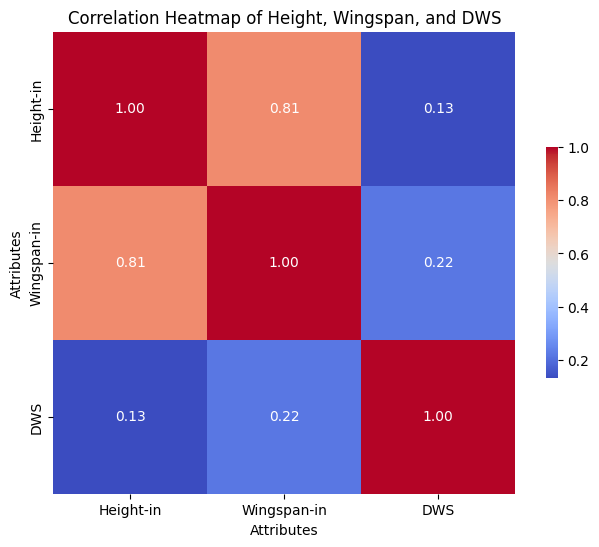

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your dataset
df = pd.read_csv("C:/Users/tajin/Downloads/final-player-data-all.csv")

# Ensure that 'Height-in' and 'Wingspan-in' are numeric
df['Height-in'] = pd.to_numeric(df['Height-in'], errors='coerce')
df['Wingspan-in'] = pd.to_numeric(df['Wingspan-in'], errors='coerce')

# Select only the relevant columns
df = df[['Height-in', 'Wingspan-in', 'DWS']]

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Calculate the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.5})

# Add titles and labels for clarity
plt.title('Correlation Heatmap of Height, Wingspan, and DWS')
plt.xlabel('Attributes')
plt.ylabel('Attributes')

# Show the plot
plt.show()


In [24]:
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.static import teams

# Get all teams
nba_teams = teams.get_teams()

# DataFrame to hold all the teams' stats
teams_stats_df = pd.DataFrame()

# Extract team stats for each team
for team in nba_teams:
    team_id = team['id']
    team_stats = teamyearbyyearstats.TeamYearByYearStats(team_id=team_id).get_data_frames()[0]
    teams_stats_df = pd.concat([teams_stats_df, team_stats])

# Filter the DataFrame to include only the columns we need
teams_stats_df = teams_stats_df[['TEAM_NAME', 'GP', 'FG3M', 'FG3_PCT', 'PTS_RANK']]

# Check for any missing data
teams_stats_df.dropna(inplace=True)

# Prepare the data for regression
X = teams_stats_df[['FG3M', 'FG3_PCT']]  # Independent variables: FG3A and FG3_PCT
y = teams_stats_df['PTS_RANK']  # Dependent variable: WINS

# Create and fit the regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

# Output the coefficients
print(f"Coefficients for Total 3-Pointers Attempted and 3-Point Percentage: {regression_model.coef_}")

# Make predictions
predictions = regression_model.predict(X)

# Calculate metrics
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Coefficients for Total 3-Pointers Attempted and 3-Point Percentage: [-2.56460801e-03  2.10310554e+01]
Mean Squared Error: 59.631849703954494
R-squared: 0.11049833187314118


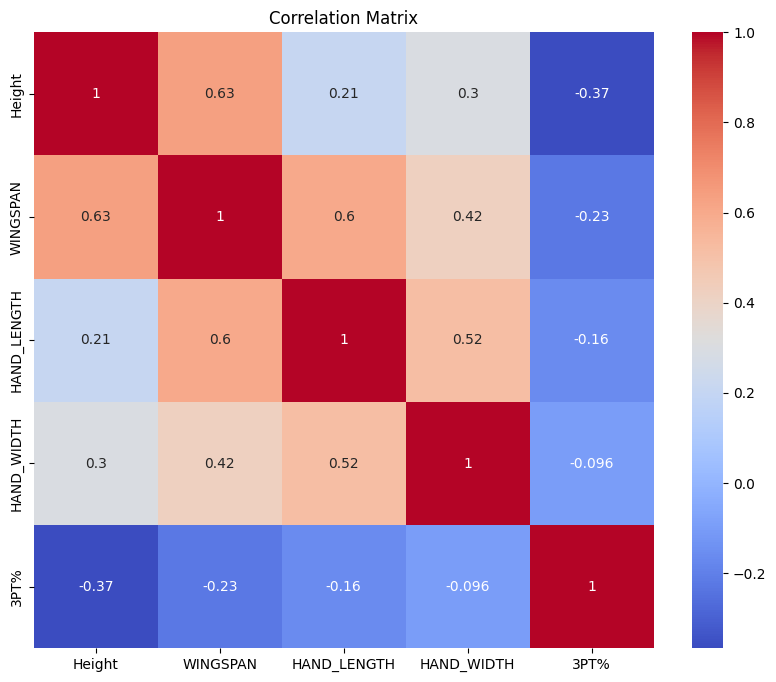

In [32]:
corr = df[['Height', 'WINGSPAN', 'HAND_LENGTH', 'HAND_WIDTH', '3PT%']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()